# CDF Graphs

In [1]:
import os,sys
sys.path.append(os.path.abspath('../Software/rate_analysis/'))
import rate_methods as RM
import numpy as np
from matplotlib import pyplot as plt
from scipy import optimize, stats
import seaborn as sns
import json

In [2]:
def get_EATR_CDF(k0, gamma, beta, directory, colvar_name, log_name, plog_len, biascol, t=None):
    print(f"{directory}")
    colvars = []
    plogs = []
    runs = [f"run_{i+1}" for i in range(100)]
    for run in runs:
        colvars.append(f"{directory}/{run}/{colvar_name}")
        plogs.append(f"{directory}/{run}/{log_name}")
        
    colvars_count = len(colvars)
    colvars_maxrow_count = None
    
    data = []
    times = []
    for colvar in colvars:
        data.append(np.loadtxt(colvar))
        times.append(data[-1][-1][0])
        colvars_maxrow_count = data[-1].shape[0] if colvars_maxrow_count is None or colvars_maxrow_count < data[-1].shape[0] else colvars_maxrow_count
    
    event = []
    for plog in plogs:
        with open(plog,'r') as f:
            if len(f.readlines()) > plog_len:
                event.append(True)
            else:
                event.append(False)
    event = np.array(event)
    M = event.sum()
    
    times = np.sort(times)
    v_data, ix_col = RM.inst_bias(data, colvars_count, colvars_maxrow_count, beta, biascol)
    spline = RM.EATR_calculate_avg_acc(gamma, v_data, beta, ix_col)
    if t is not None:
        return times, RM.EATR_CDF(t, k0, gamma, spline, 1), M
    return times, RM.EATR_CDF(times, k0, gamma, spline, 1), M

def just_times(directory, colvar_name, log_name, plog_len):
    
    colvars = []
    plogs = []
    runs = [f"run_{i+1}" for i in range(100)]
    for run in runs:
        colvars.append(f"{directory}/{run}/{colvar_name}")
        plogs.append(f"{directory}/{run}/{log_name}")
    
    times = []
    for colvar in colvars:
        times.append(np.loadtxt(colvar)[-1][0])
    times = np.array(times)
        
    event = []
    for plog in plogs:
        with open(plog,'r') as f:
            if len(f.readlines()) > plog_len:
                event.append(True)
            else:
                event.append(False)
    event = np.array(event)
        
    return np.sort(times[event]), event.sum()

## Matched-Harmonic Potential

In [3]:
unbiased_data = np.loadtxt('../Data/X_matched_harmonics_wt/unbiased_output.dat')

def tcdf(t,k):
    return 1 - np.exp(-k*t)

def ecdf(res_t):
    x = np.sort(res_t)
    n = 200
    ntrans = x.size
    y = np.linspace(0,1,n+1)[1:ntrans+1]
    return x, y

unbiased_ecdfx, unbiased_ecdfy = ecdf(unbiased_data[:,0])

k_fit = 1.03793094e-06
unbiased_tcdfx = np.linspace(1e3,7e6,1000)
unbiased_tcdfy_fit = tcdf(unbiased_tcdfx,k_fit)

k_kramers = 9.491650747250123e-07
unbiased_tcdfy_kramers = tcdf(unbiased_tcdfx,k_kramers)

In [4]:
with open('Rates/rates_X_gamma1_wt.json') as f:
    rates_gamma1 = json.load(f)["EATR CDF k"]

y_cdfs = np.linspace(0,1,101)[1:]
    
x1e3, y1e3, _ = get_EATR_CDF(rates_gamma1[0], 1.0, 1.0, '../Data/X_matched_harmonics_wt/xruns_pace1e3', 'metad.colvar', 'metad.colvar', 1, 2)
x1e4, y1e4, _ = get_EATR_CDF(rates_gamma1[1], 1.0, 1.0, '../Data/X_matched_harmonics_wt/xruns_pace1e4', 'metad.colvar', 'metad.colvar', 1, 2)
x1e5, y1e5, _ = get_EATR_CDF(rates_gamma1[2], 1.0, 1.0, '../Data/X_matched_harmonics_wt/xruns_pace1e5', 'metad.colvar', 'metad.colvar', 1, 2)
x1e6, y1e6, _ = get_EATR_CDF(rates_gamma1[3], 1.0, 1.0, '../Data/X_matched_harmonics_wt/xruns_pace1e6', 'metad.colvar', 'metad.colvar', 1, 2)

../Data/X_matched_harmonics_wt/xruns_pace1e3
../Data/X_matched_harmonics_wt/xruns_pace1e4
../Data/X_matched_harmonics_wt/xruns_pace1e5
../Data/X_matched_harmonics_wt/xruns_pace1e6


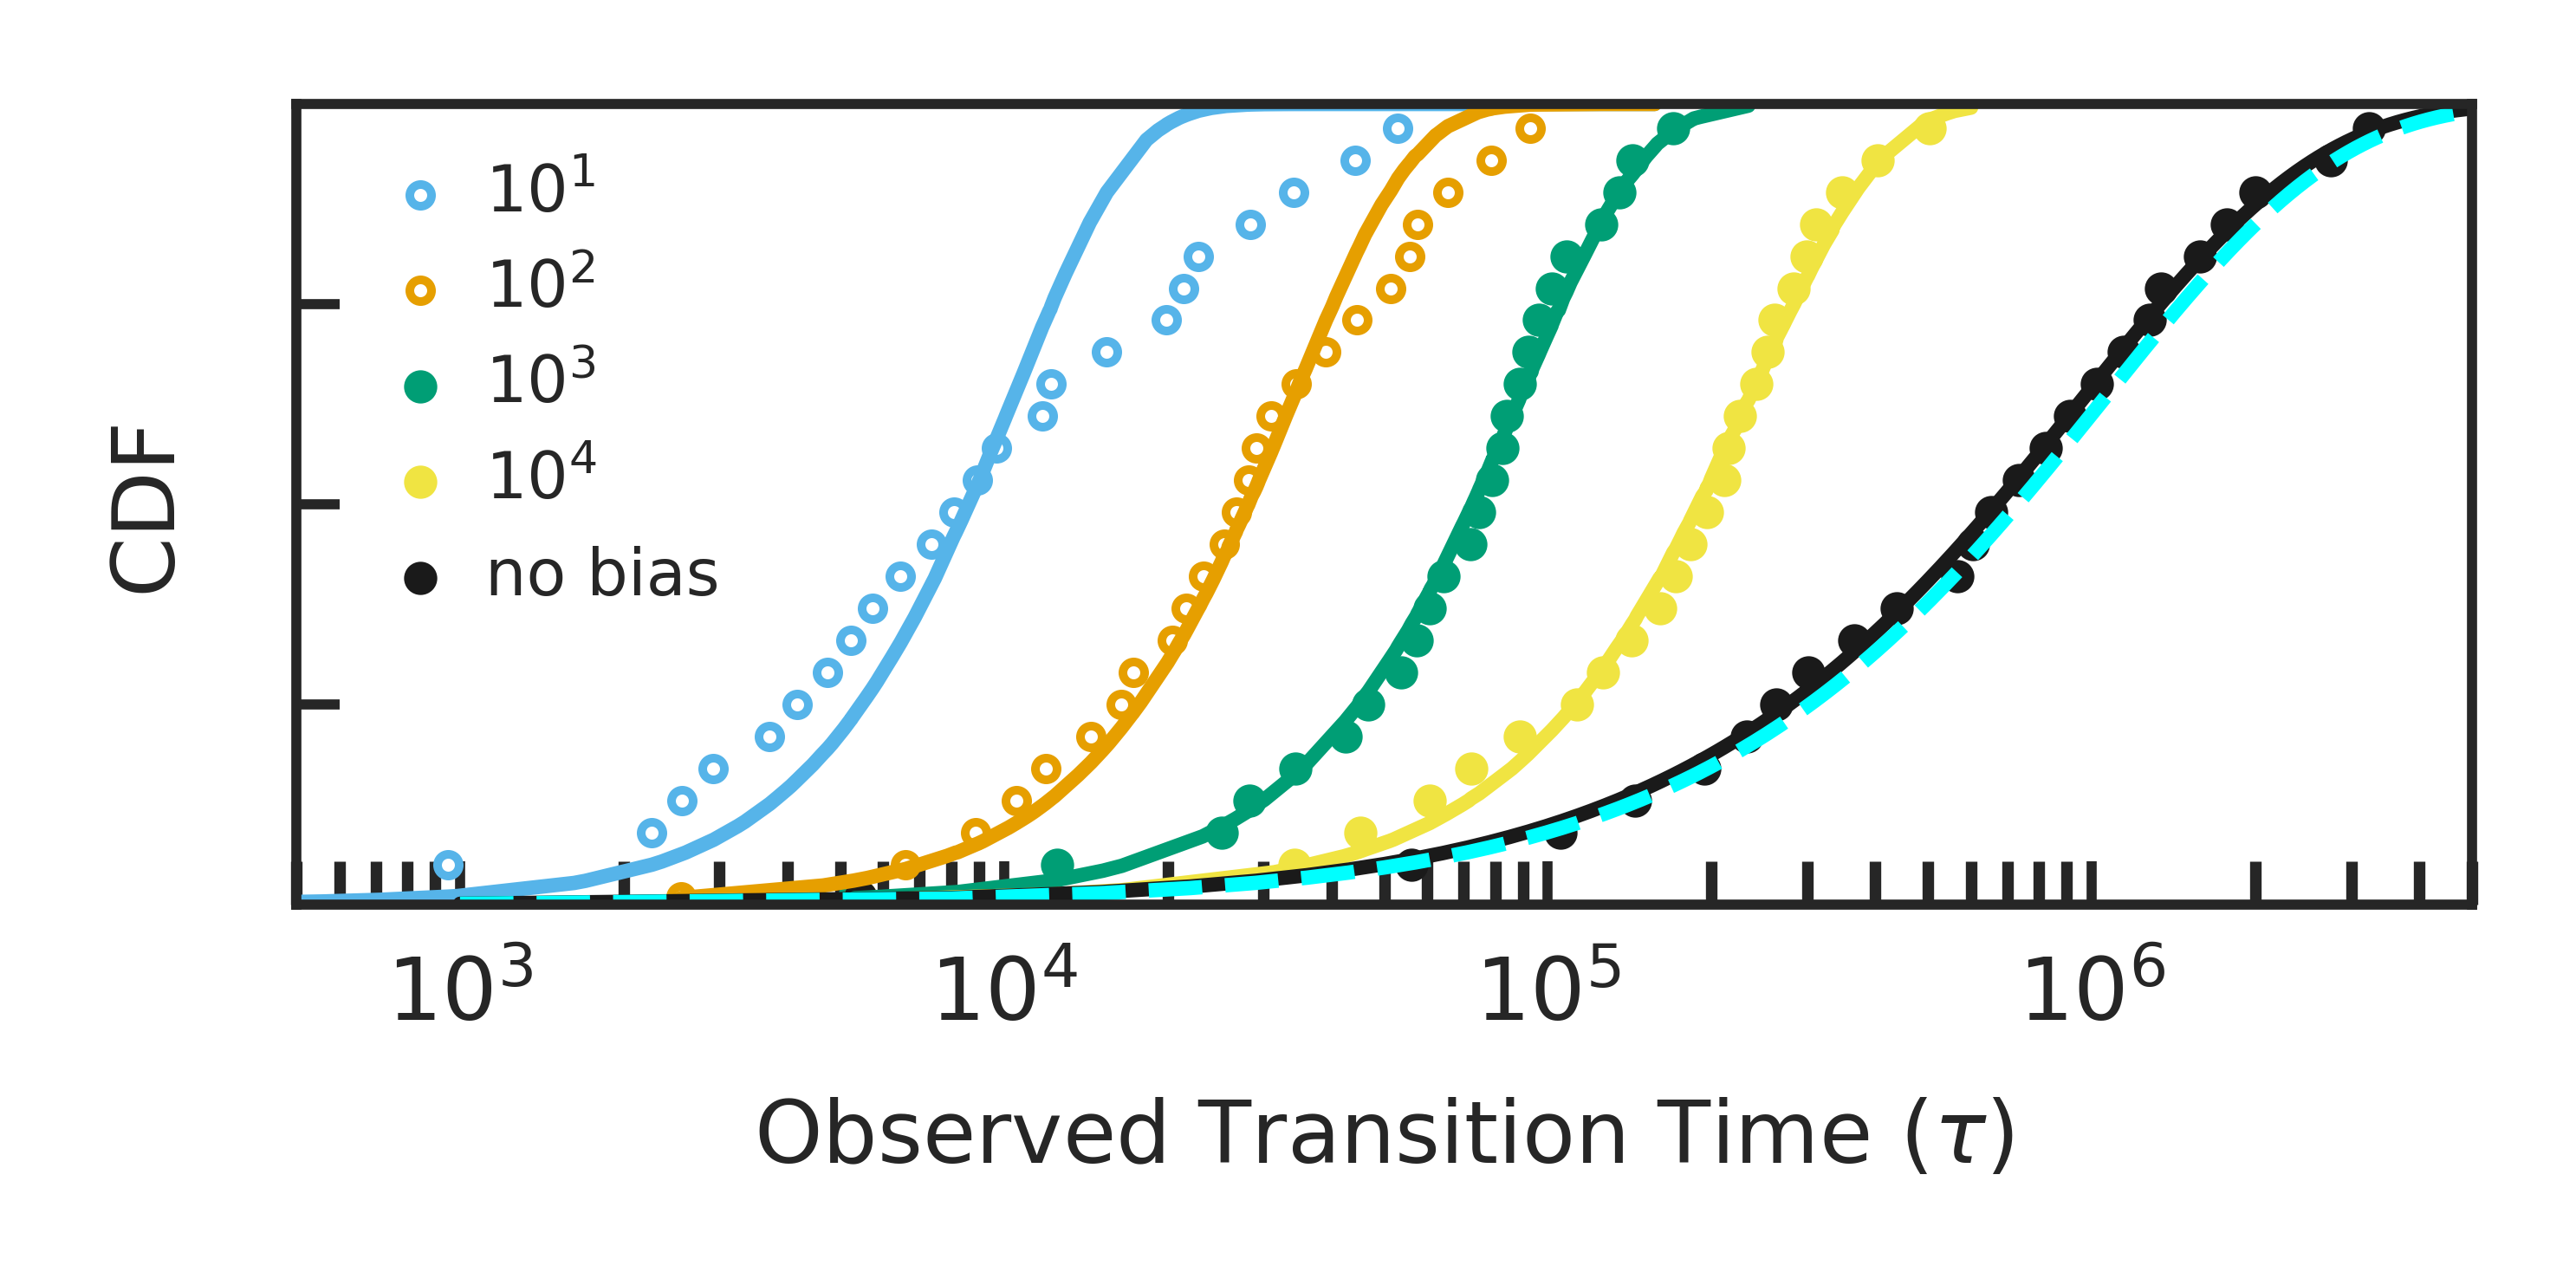

In [5]:
sns.set_theme()
sns.set_style('ticks')
sns.set_context('paper', rc={'axes.labelsize': 6, 'axes.linewidth': 0.7, 'lines.linewidth': 1.0,
                             'xtick.labelsize': 6, 'ytick.labelsize': 6, 'xtick.major.width': 0.7, 'ytick.major.width': 0.7,
                             'legend.fontsize': 4.5, 'legend.framealpha': 0, 'lines.markersize': 3})

fig,ax = plt.subplots(figsize=(2.7,1.),dpi=1200)
ax.set_xlabel('Observed Transition Time ($\\tau$)')
ax.set_ylabel('CDF')
ax.set_xlim((5e2,5e6))
ax.set_ylim((0,1))
ax.set_yticks([0.25,0.5,0.75],labels=['','',''])
plt.xscale('log')


ax.scatter(x1e3[::4],y_cdfs[::4],color='#FFFFFF',marker='.',edgecolors='#56B4E9',linewidths=0.6,label='$10^1$')
ax.plot(x1e3,y1e3,color="#56B4E9",linestyle='-')
ax.scatter(x1e4[::4],y_cdfs[::4],color='#FFFFFF',marker='.',edgecolors='#E69F00',linewidths=0.6,label='$10^2$')
ax.plot(x1e4,y1e4,color="#E69F00",linestyle='-')
ax.scatter(x1e5[::4],y_cdfs[::4],color='#009E75',marker='.',label='$10^3$')
ax.plot(x1e5,y1e5,color="#009E75",linestyle='-')
ax.scatter(x1e6[::4],y_cdfs[::4],color="#F0E442",marker='.',label='$10^4$')
ax.plot(x1e6,y1e6,color="#F0E442",linestyle='-')
ax.scatter(unbiased_ecdfx[1::8],unbiased_ecdfy[1::8],color="k",marker='.',label='no bias')
ax.plot(unbiased_tcdfx,unbiased_tcdfy_fit,color="k",linestyle='-')
ax.plot(unbiased_tcdfx,unbiased_tcdfy_kramers,color='cyan',linestyle='--')
ax.legend(frameon=False,handletextpad=0)
ax.tick_params(axis='both', direction='in', which='both', length=3)

In [6]:
with open('Rates/rates_X_wt.json') as f:
    rates_gammas = json.load(f)

y_cdfs_fit = np.linspace(0,1,101)[1:]
    
x1e3_fit, y1e3_fit, _ = get_EATR_CDF(rates_gammas["EATR CDF k"][0], rates_gammas["EATR CDF g"][0], 1.0, '../Data/X_matched_harmonics_wt/xruns_pace1e3', 'metad.colvar', 'metad.colvar', 1, 2)
x1e4_fit, y1e4_fit, _ = get_EATR_CDF(rates_gammas["EATR CDF k"][1], rates_gammas["EATR CDF g"][1], 1.0, '../Data/X_matched_harmonics_wt/xruns_pace1e4', 'metad.colvar', 'metad.colvar', 1, 2)
x1e5_fit, y1e5_fit, _ = get_EATR_CDF(rates_gammas["EATR CDF k"][2], rates_gammas["EATR CDF g"][2], 1.0, '../Data/X_matched_harmonics_wt/xruns_pace1e5', 'metad.colvar', 'metad.colvar', 1, 2)
x1e6_fit, y1e6_fit, _ = get_EATR_CDF(rates_gammas["EATR CDF k"][3], rates_gammas["EATR CDF g"][3], 1.0, '../Data/X_matched_harmonics_wt/xruns_pace1e6', 'metad.colvar', 'metad.colvar', 1, 2)

../Data/X_matched_harmonics_wt/xruns_pace1e3
../Data/X_matched_harmonics_wt/xruns_pace1e4
../Data/X_matched_harmonics_wt/xruns_pace1e5
../Data/X_matched_harmonics_wt/xruns_pace1e6


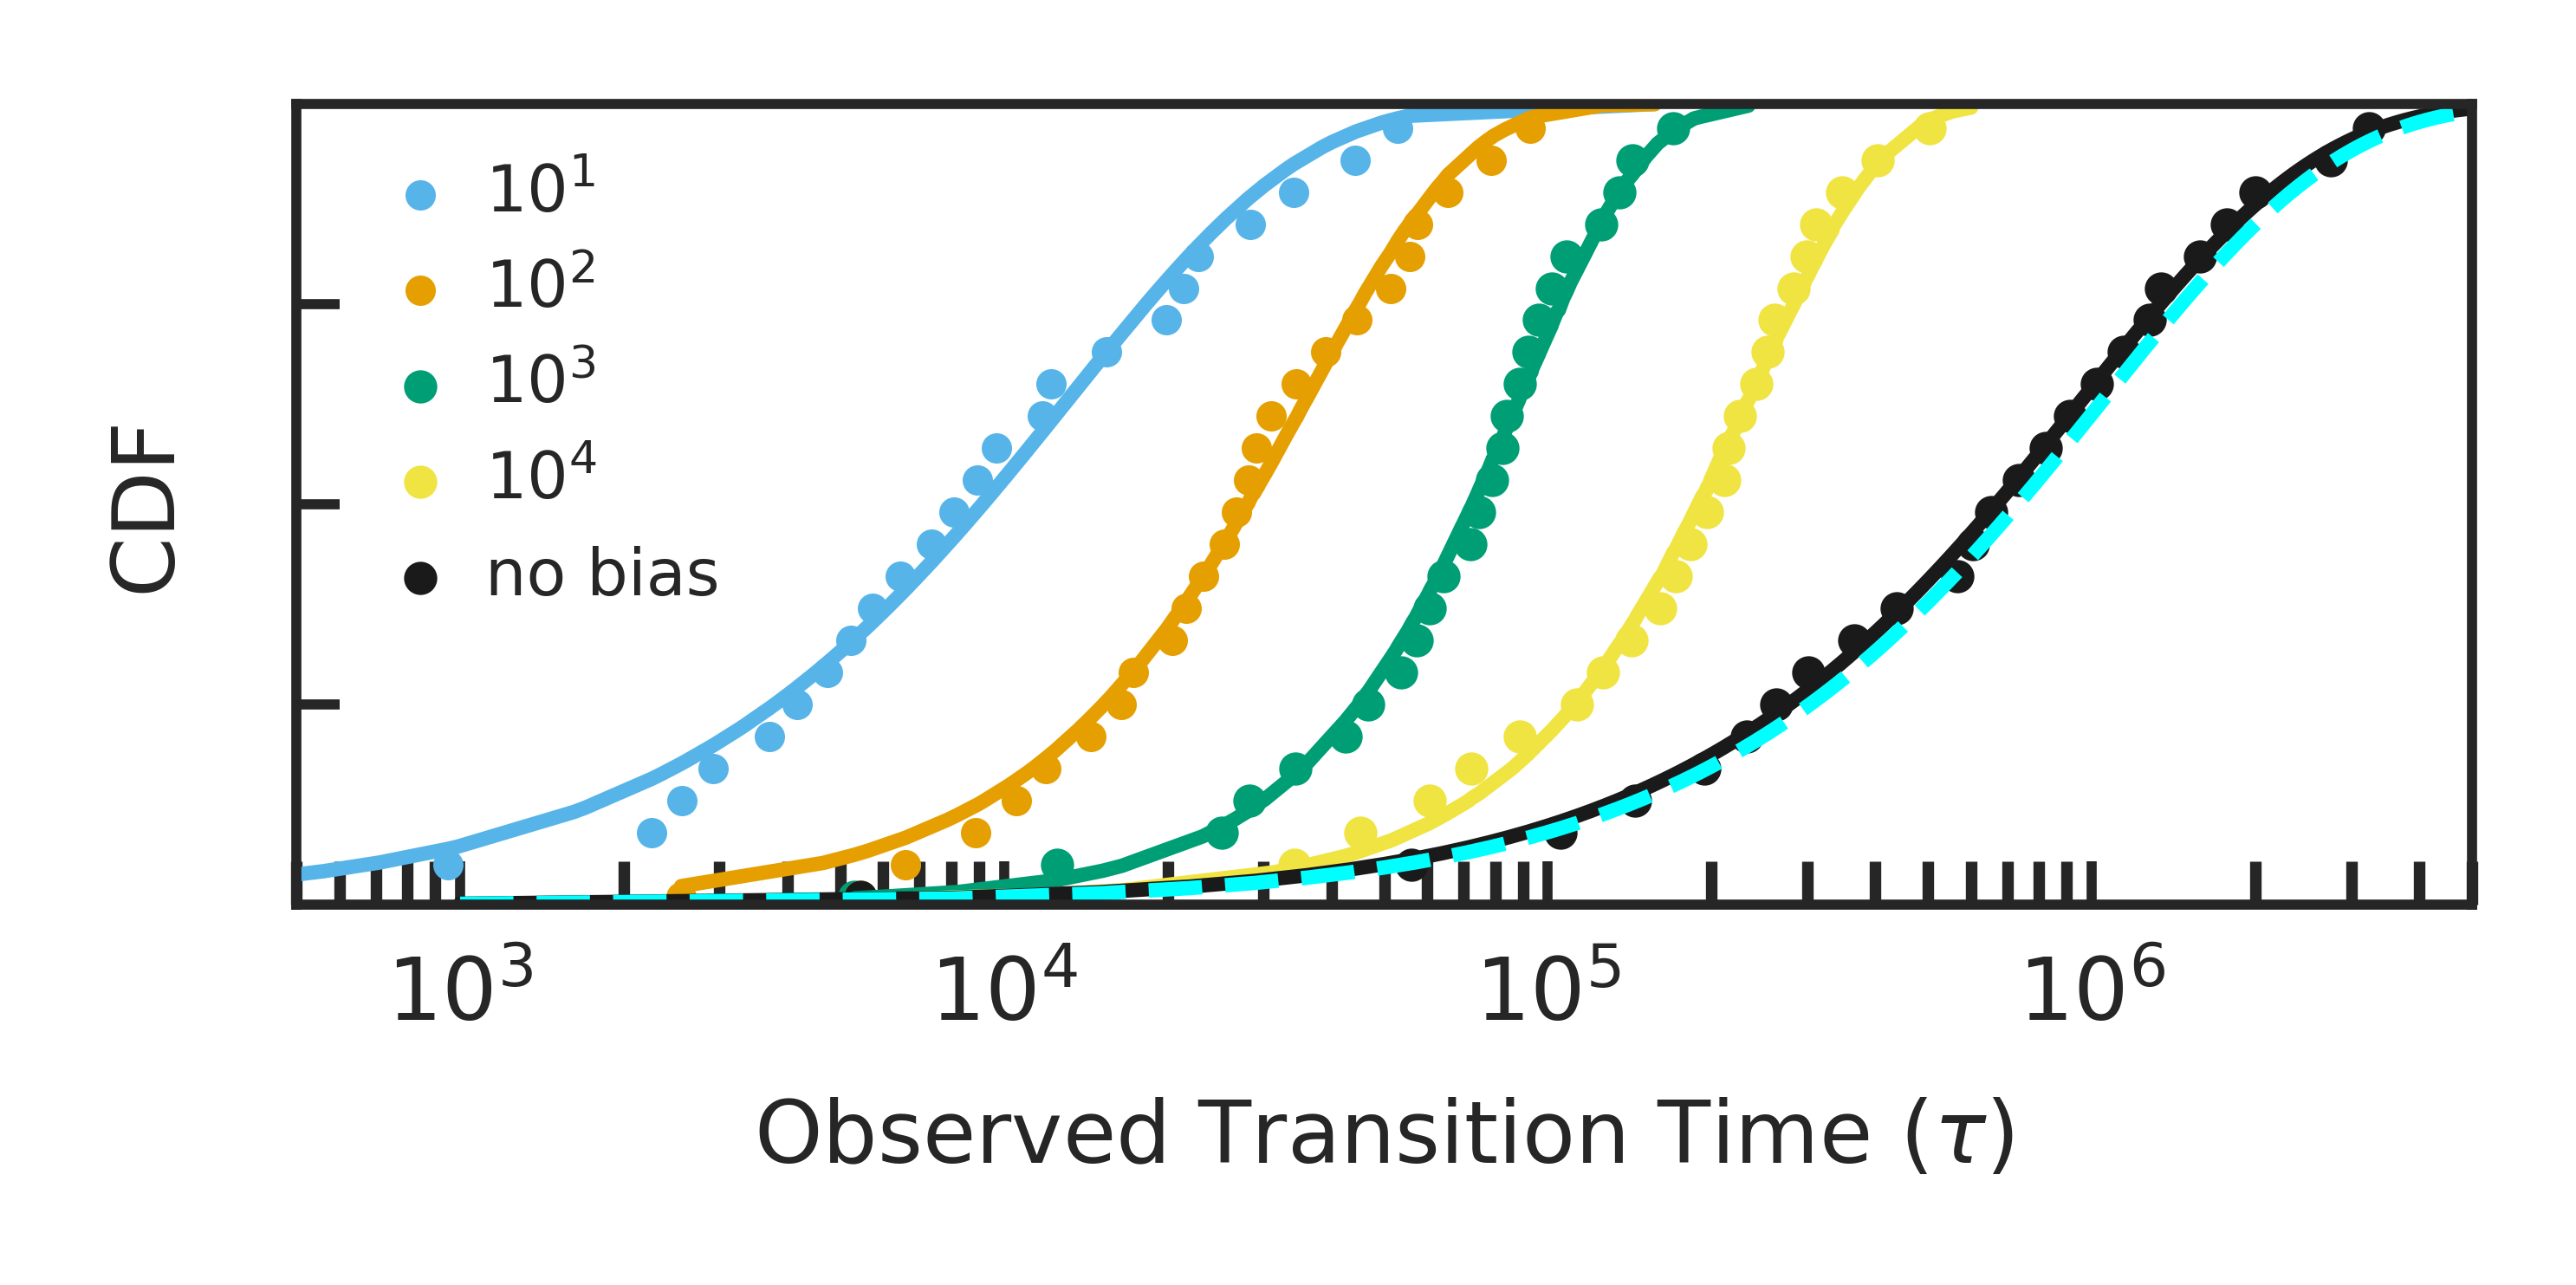

In [7]:
sns.set_theme()
sns.set_style('ticks')
sns.set_context('paper', rc={'axes.labelsize': 6, 'axes.linewidth': 0.7, 'lines.linewidth': 1.0,
                             'xtick.labelsize': 6, 'ytick.labelsize': 6, 'xtick.major.width': 0.7, 'ytick.major.width': 0.7,
                             'legend.fontsize': 4.5, 'legend.framealpha': 0, 'lines.markersize': 3})

fig,ax = plt.subplots(figsize=(2.7,1.),dpi=1200)
ax.set_xlabel('Observed Transition Time ($\\tau$)')
ax.set_ylabel('CDF')
ax.set_xlim((5e2,5e6))
ax.set_ylim((0,1))
ax.set_yticks([0.25,0.5,0.75],labels=['','',''])
plt.xscale('log')

ax.scatter(x1e3_fit[::4],y_cdfs_fit[::4],color='#56B4E9',marker='.',linewidths=0.6,label='$10^1$')
ax.plot(x1e3_fit,y1e3_fit,color="#56B4E9",linestyle='-')
ax.scatter(x1e4_fit[::4],y_cdfs_fit[::4],color='#E69F00',marker='.',linewidths=0.6,label='$10^2$')
ax.plot(x1e4_fit,y1e4_fit,color="#E69F00",linestyle='-')
ax.scatter(x1e5_fit[::4],y_cdfs_fit[::4],color='#009E75',marker='.',label='$10^3$')
ax.plot(x1e5_fit,y1e5_fit,color="#009E75",linestyle='-')
ax.scatter(x1e6_fit[::4],y_cdfs_fit[::4],color="#F0E442",marker='.',label='$10^4$')
ax.plot(x1e6_fit,y1e6_fit,color="#F0E442",linestyle='-')
ax.scatter(unbiased_ecdfx[1::8],unbiased_ecdfy[1::8],color="k",marker='.',label='no bias')
ax.plot(unbiased_tcdfx,unbiased_tcdfy_fit,color="k",linestyle='-')
ax.plot(unbiased_tcdfx,unbiased_tcdfy_kramers,color='cyan',linestyle='--')
ax.legend(frameon=False,handletextpad=0)
ax.tick_params(axis='both', direction='in', which='both', length=3)

## Protein G 2D CV

In [8]:
headdir = "../Data/2D_GE_wt/"
directories = ['geruns_pace1e2','geruns_pace1e3','geruns_pace1e4','geruns_pace2e4','geruns_pace5e4','geruns_pace1e5','geruns_pace5e5','geruns_pace1e6']

with open("Rates/rates_GE_wt.json", 'r') as f:
    rates_data = json.load(f)

ecdfxs = []
ecdfys = []
tcdfxs = []
tcdfys = []

for i, directory in enumerate(directories):
    ts, M = just_times(headdir+directory,"metad.colvar","p.log",159)
    ecdfxs.append(ts)
    ecdfys.append(np.arange(1, M+1) / 100.)
    tcdfxs.append(10**np.linspace( np.log10(ts[0])-0.3, np.log10(ts[-1])+0.3, 500 ))
    tcdfys.append(get_EATR_CDF(rates_data["EATR CDF k"][i], rates_data["EATR CDF g"][i], 0.3855097673, headdir+directory, "metad.colvar", "p.log", 159, 3, t=tcdfxs[-1])[1])

../Data/2D_GE_wt/geruns_pace1e2
../Data/2D_GE_wt/geruns_pace1e3
../Data/2D_GE_wt/geruns_pace1e4
../Data/2D_GE_wt/geruns_pace2e4
../Data/2D_GE_wt/geruns_pace5e4
../Data/2D_GE_wt/geruns_pace1e5
../Data/2D_GE_wt/geruns_pace5e5
../Data/2D_GE_wt/geruns_pace1e6


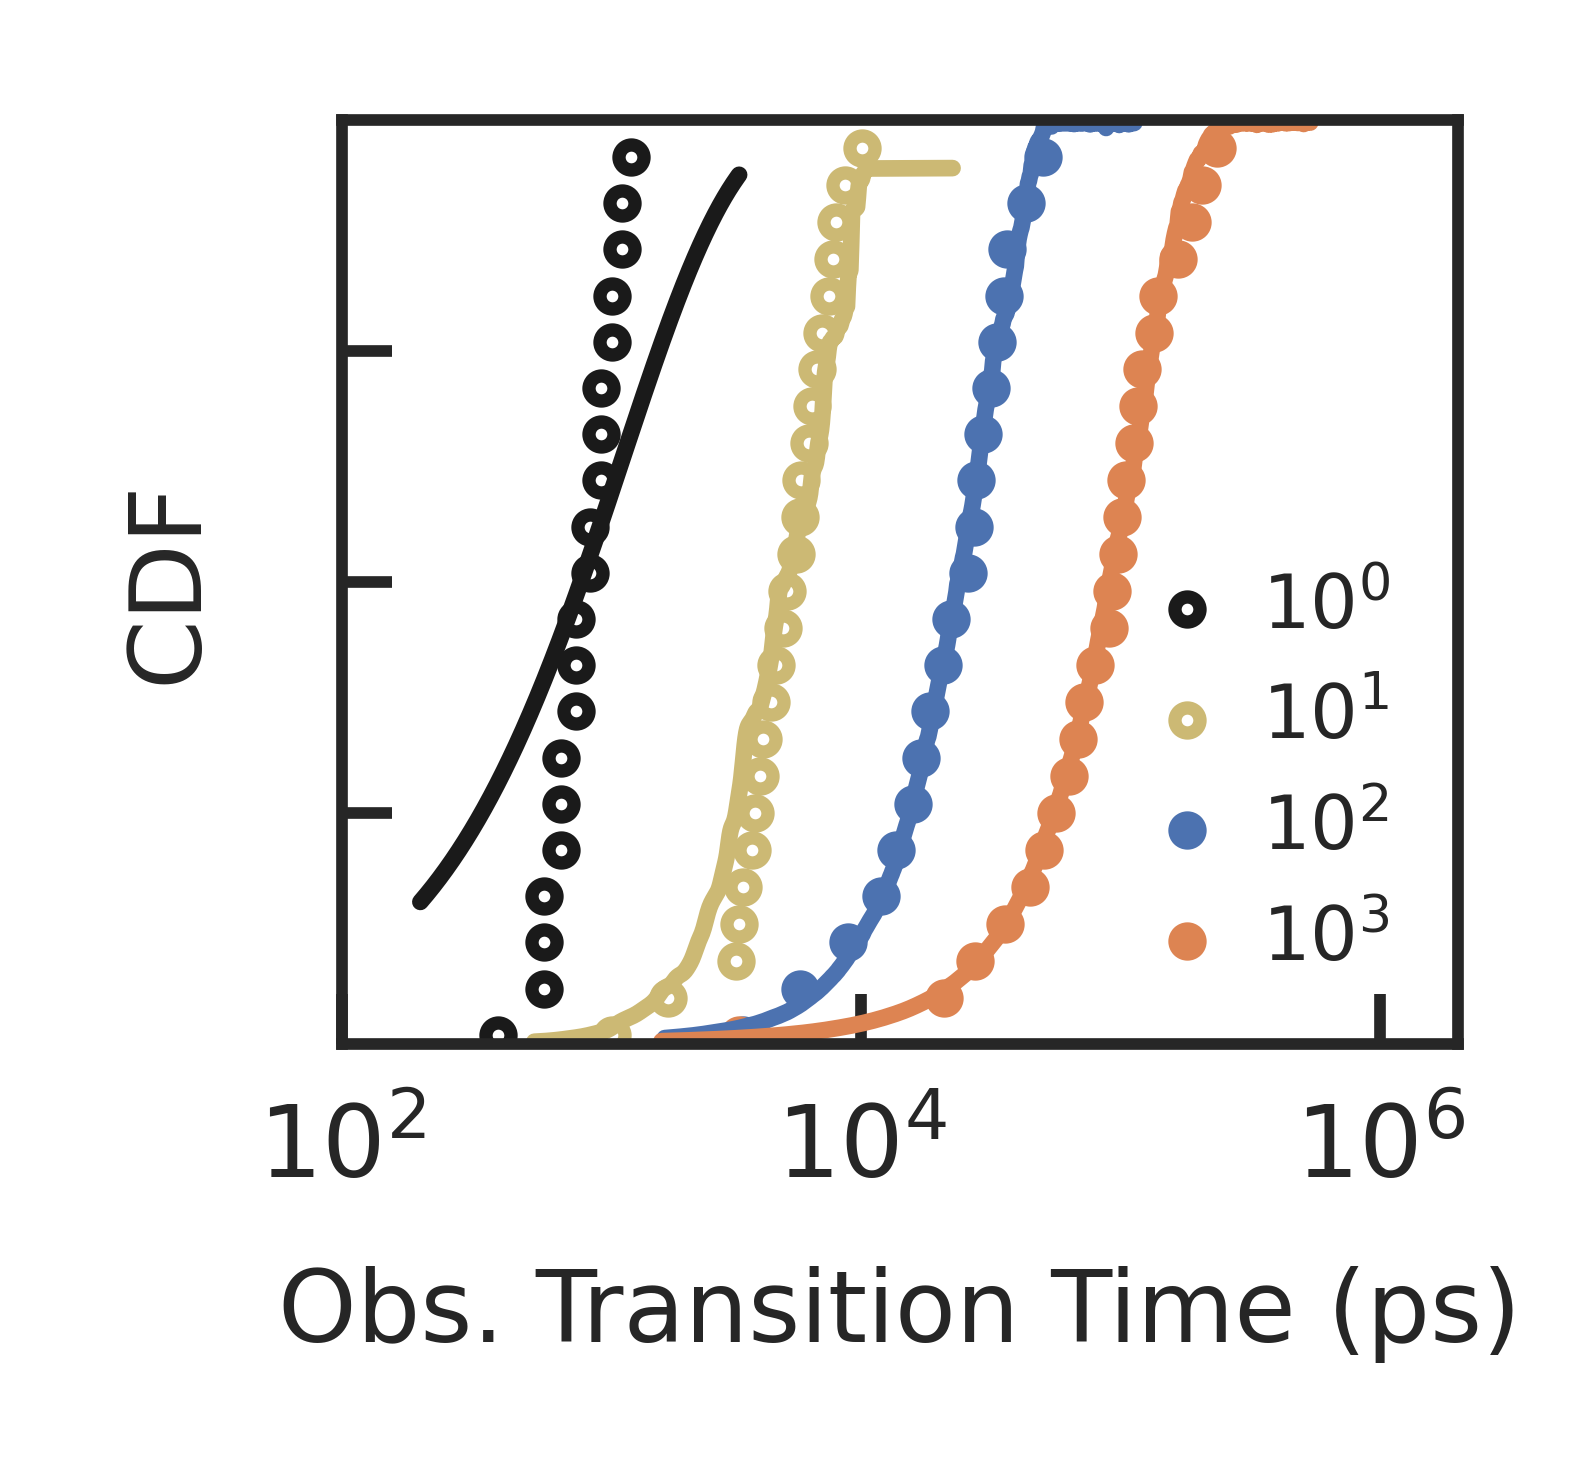

In [9]:
sns.set_theme()
sns.set_style('ticks')
sns.set_context('paper', rc={'axes.labelsize': 6, 'axes.linewidth': 0.7, 'lines.linewidth': 1.0,
                             'xtick.labelsize': 6, 'ytick.labelsize': 6, 'xtick.major.width': 0.7, 'ytick.major.width': 0.7,
                             'legend.fontsize': 4.5, 'legend.framealpha': 0, 'lines.markersize': 3})

fig,ax = plt.subplots(figsize=(1.2,1.),dpi=1200)
ax.set_xlabel('Obs. Transition Time (ps)')
ax.set_ylabel('CDF')
ax.set_xlim((1e2,2e6))
ax.set_ylim((0,1))
plt.xscale('log')

colors=['k',"#F0E442",'#56B4E9','#009E75','#E69F00']


ax.plot(tcdfxs[0],tcdfys[0],linestyle='-',color='k')
ax.scatter(ecdfxs[0][::5],ecdfys[0][::5],marker='.',color='#FFFFFF',edgecolors='k',label='$10^0$')

ax.plot(tcdfxs[1],tcdfys[1],linestyle='-',color='y')
ax.scatter(ecdfxs[1][::4],ecdfys[1][::4],marker='.',color='#FFFFFF',edgecolors='y',label='$10^1$')

ax.plot(tcdfxs[2],tcdfys[2],linestyle='-')
ax.scatter(ecdfxs[2][::5],ecdfys[2][::5],marker='.',label='$10^2$')

ax.plot(tcdfxs[5],tcdfys[5],linestyle='-')
ax.scatter(ecdfxs[5][::4],ecdfys[5][::4],marker='.',label='$10^3$')

ax.set_yticks([0.25,0.5,0.75],labels=['','',''])
plt.tick_params(axis='both', direction='in', which='both',length=3)
ax.legend(loc="lower right",frameon=False,handletextpad=0)

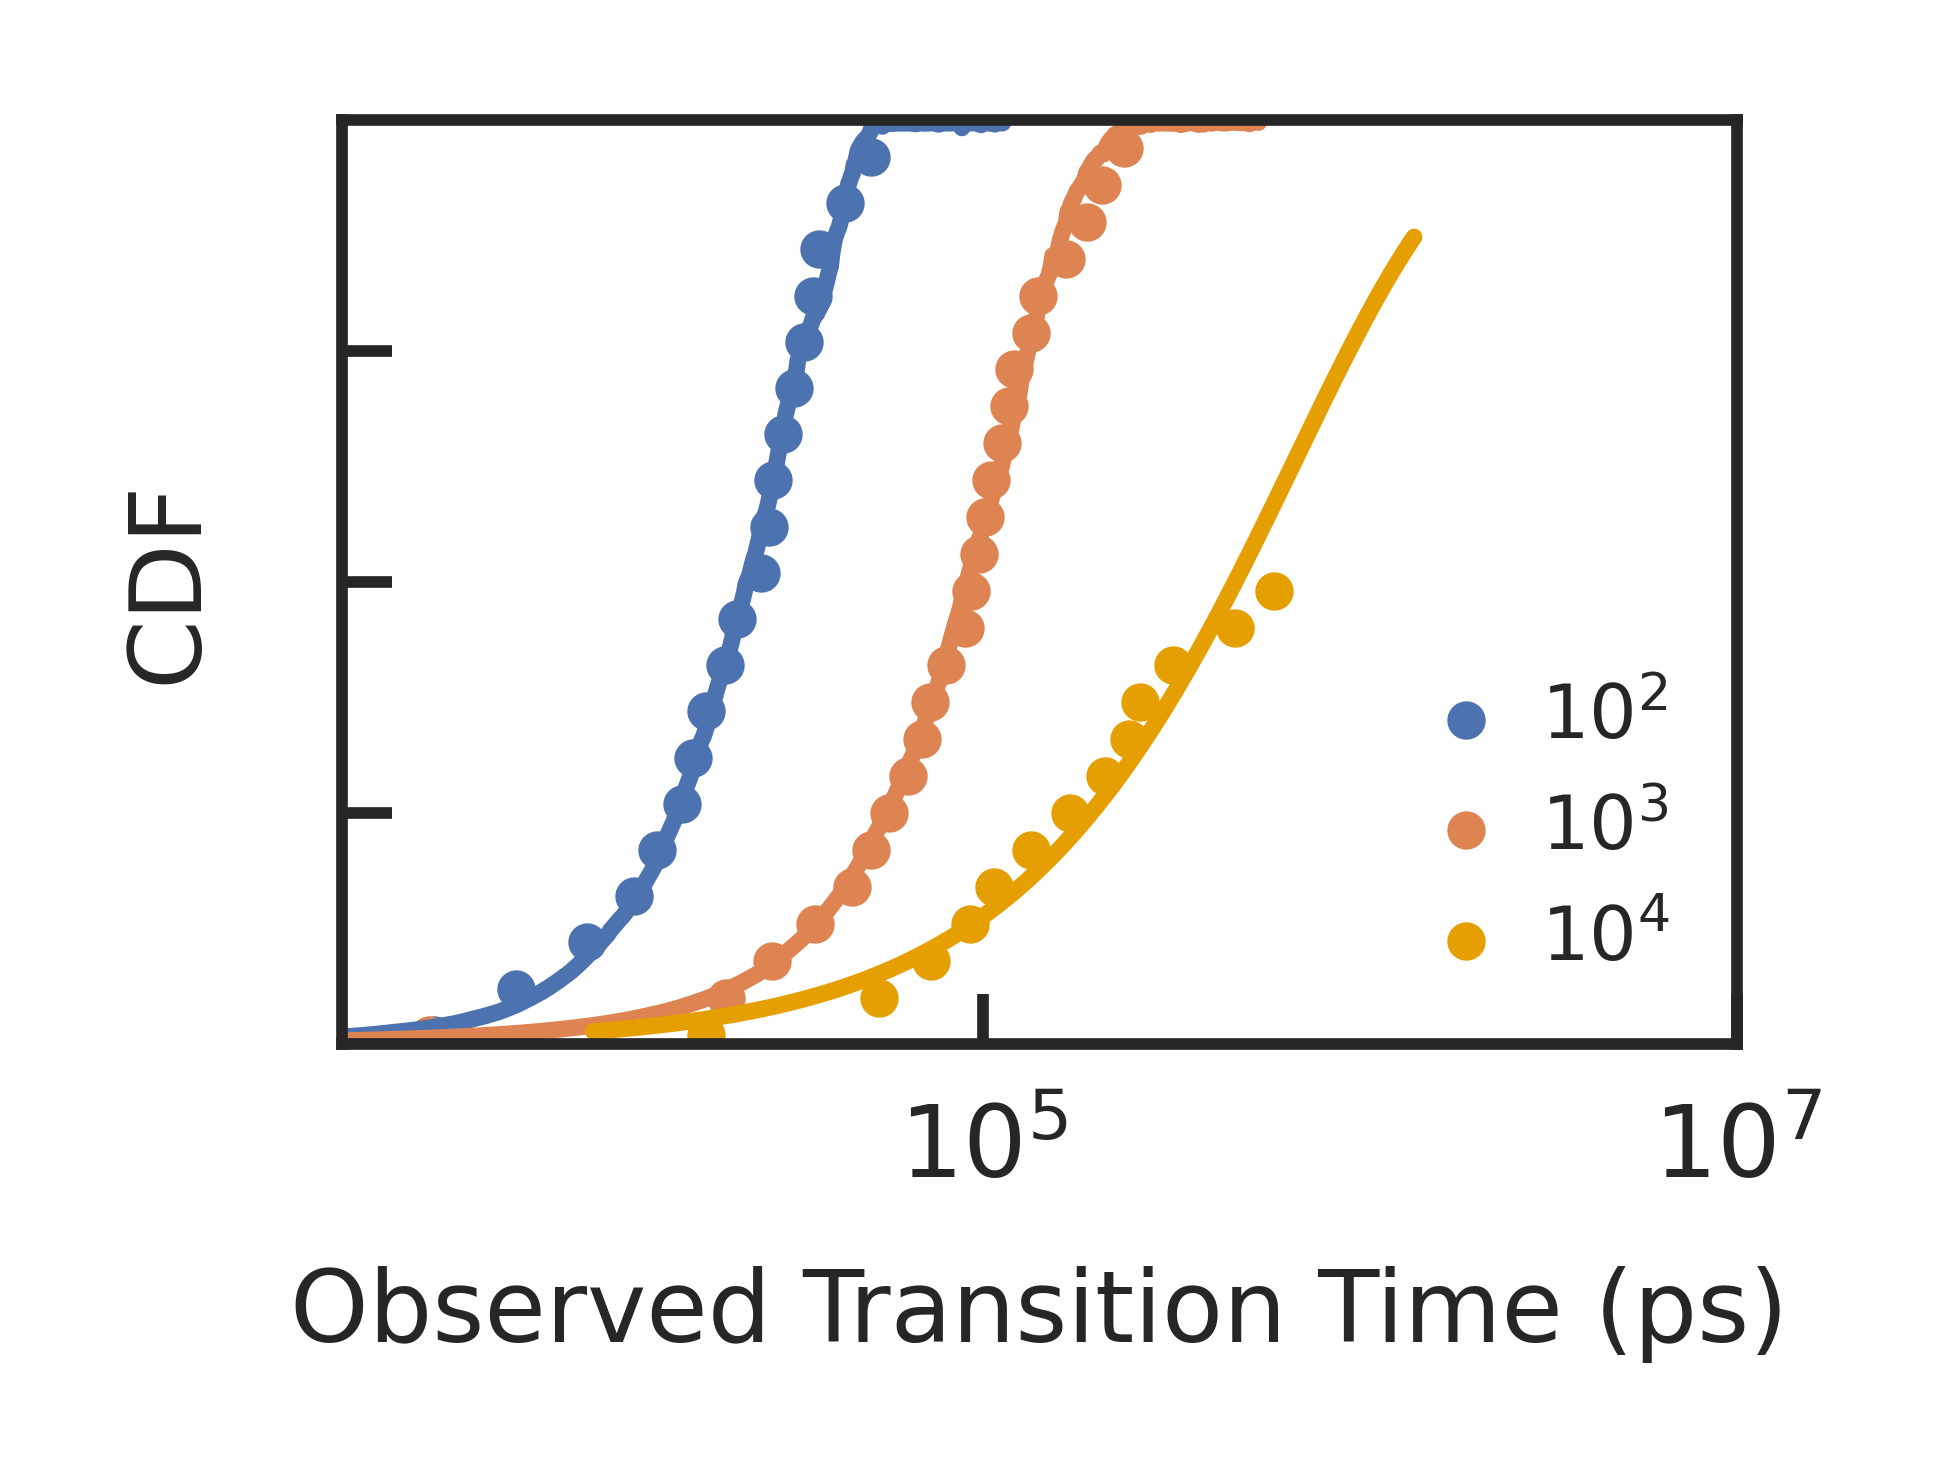

In [10]:
sns.set_theme()
sns.set_style('ticks')
sns.set_context('paper', rc={'axes.labelsize': 6, 'axes.linewidth': 0.7, 'lines.linewidth': 1.0,
                             'xtick.labelsize': 6, 'ytick.labelsize': 6, 'xtick.major.width': 0.7, 'ytick.major.width': 0.7,
                             'legend.fontsize': 4.5, 'legend.framealpha': 0, 'lines.markersize': 3})

fig,ax = plt.subplots(figsize=(1.5,1.),dpi=1200)
ax.set_xlabel('Observed Transition Time (ps)')
ax.set_ylabel('CDF')
ax.set_xlim((2e3,1e7))
ax.set_ylim((0,1))
plt.xscale('log')

colors=['k',"#F0E442",'#56B4E9','#009E75','#E69F00']


ax.plot(tcdfxs[2],tcdfys[2],linestyle='-')
ax.scatter(ecdfxs[2][::5],ecdfys[2][::5],marker='.',label='$10^2$')

ax.plot(tcdfxs[5],tcdfys[5],linestyle='-')
ax.scatter(ecdfxs[5][::4],ecdfys[5][::4],marker='.',label='$10^3$')

ax.plot(tcdfxs[7],tcdfys[7],color='#E69F00',linestyle='-')
ax.scatter(ecdfxs[7][::4],ecdfys[7][::4],color='#E69F00',marker='.',label='$10^4$')

ax.set_yticks([0.25,0.5,0.75],labels=['','',''])
plt.tick_params(axis='both', direction='in', which='both',length=3)
ax.legend(loc="lower right",frameon=False,handletextpad=0)

## Protein G LD1 $\gamma$ Ranges; $\Delta=10^3$

In [23]:
directory = "../Data/L_lda_wt/lruns_pace1e3"

gammas = np.concatenate((np.arange(0.,0.25,0.08),np.array([1.])))
print(gammas)

ecdfx, M = just_times(directory, 'metad_short.colvar', 'p.log', 169)
ecdfy = np.arange(1, M + 1) / 100.
ecdf_data=np.column_stack((ecdfx, ecdfy))

ts = 10**np.linspace(3,5,100)

colvars = []
runs = [f"run_{i+1}" for i in range(100)]
for run in runs:
    colvars.append(f"{directory}/{run}/metad_short.colvar")
colvars_count = len(colvars)
colvars_maxrow_count = None
data = []
for colvar in colvars:
    data.append(np.loadtxt(colvar))
    colvars_maxrow_count = data[-1].shape[0] if colvars_maxrow_count is None or colvars_maxrow_count < data[-1].shape[0] else colvars_maxrow_count

v_data, ix_col = RM.inst_bias(data, colvars_count, colvars_maxrow_count, 0.3855097673, 2)

[0.   0.08 0.16 0.24 1.  ]


In [24]:
tcdf_ys = []

def tcdf(t, k0, gamma):
    spline = RM.EATR_calculate_avg_acc(gamma, v_data, 0.3855097673, ix_col)
    return RM.EATR_CDF(t, k0, gamma, spline, 1)

for gamma in gammas:
    cdf_result = optimize.curve_fit(tcdf, ecdf_data[:,0], ecdf_data[:,1], p0=(1e-5,gamma), bounds=([1e-8,gamma-0.0000001],[1e-3,gamma]))
    cdf_result = cdf_result[0]
    tcdf_ys.append(tcdf(ts,cdf_result[0],cdf_result[1]))
    print(f"gamma: {cdf_result[1]}, k0: {cdf_result[0]}")

gamma: -1.850970492219394e-15, k0: 0.00010321864071921496
gamma: 0.07999999999999999, k0: 6.229683912477863e-05
gamma: 0.15999990000091693, k0: 3.5866017538700606e-05
gamma: 0.23999990039956862, k0: 1.973645064104868e-05
gamma: 0.9999999000129672, k0: 1.3908786630081995e-08


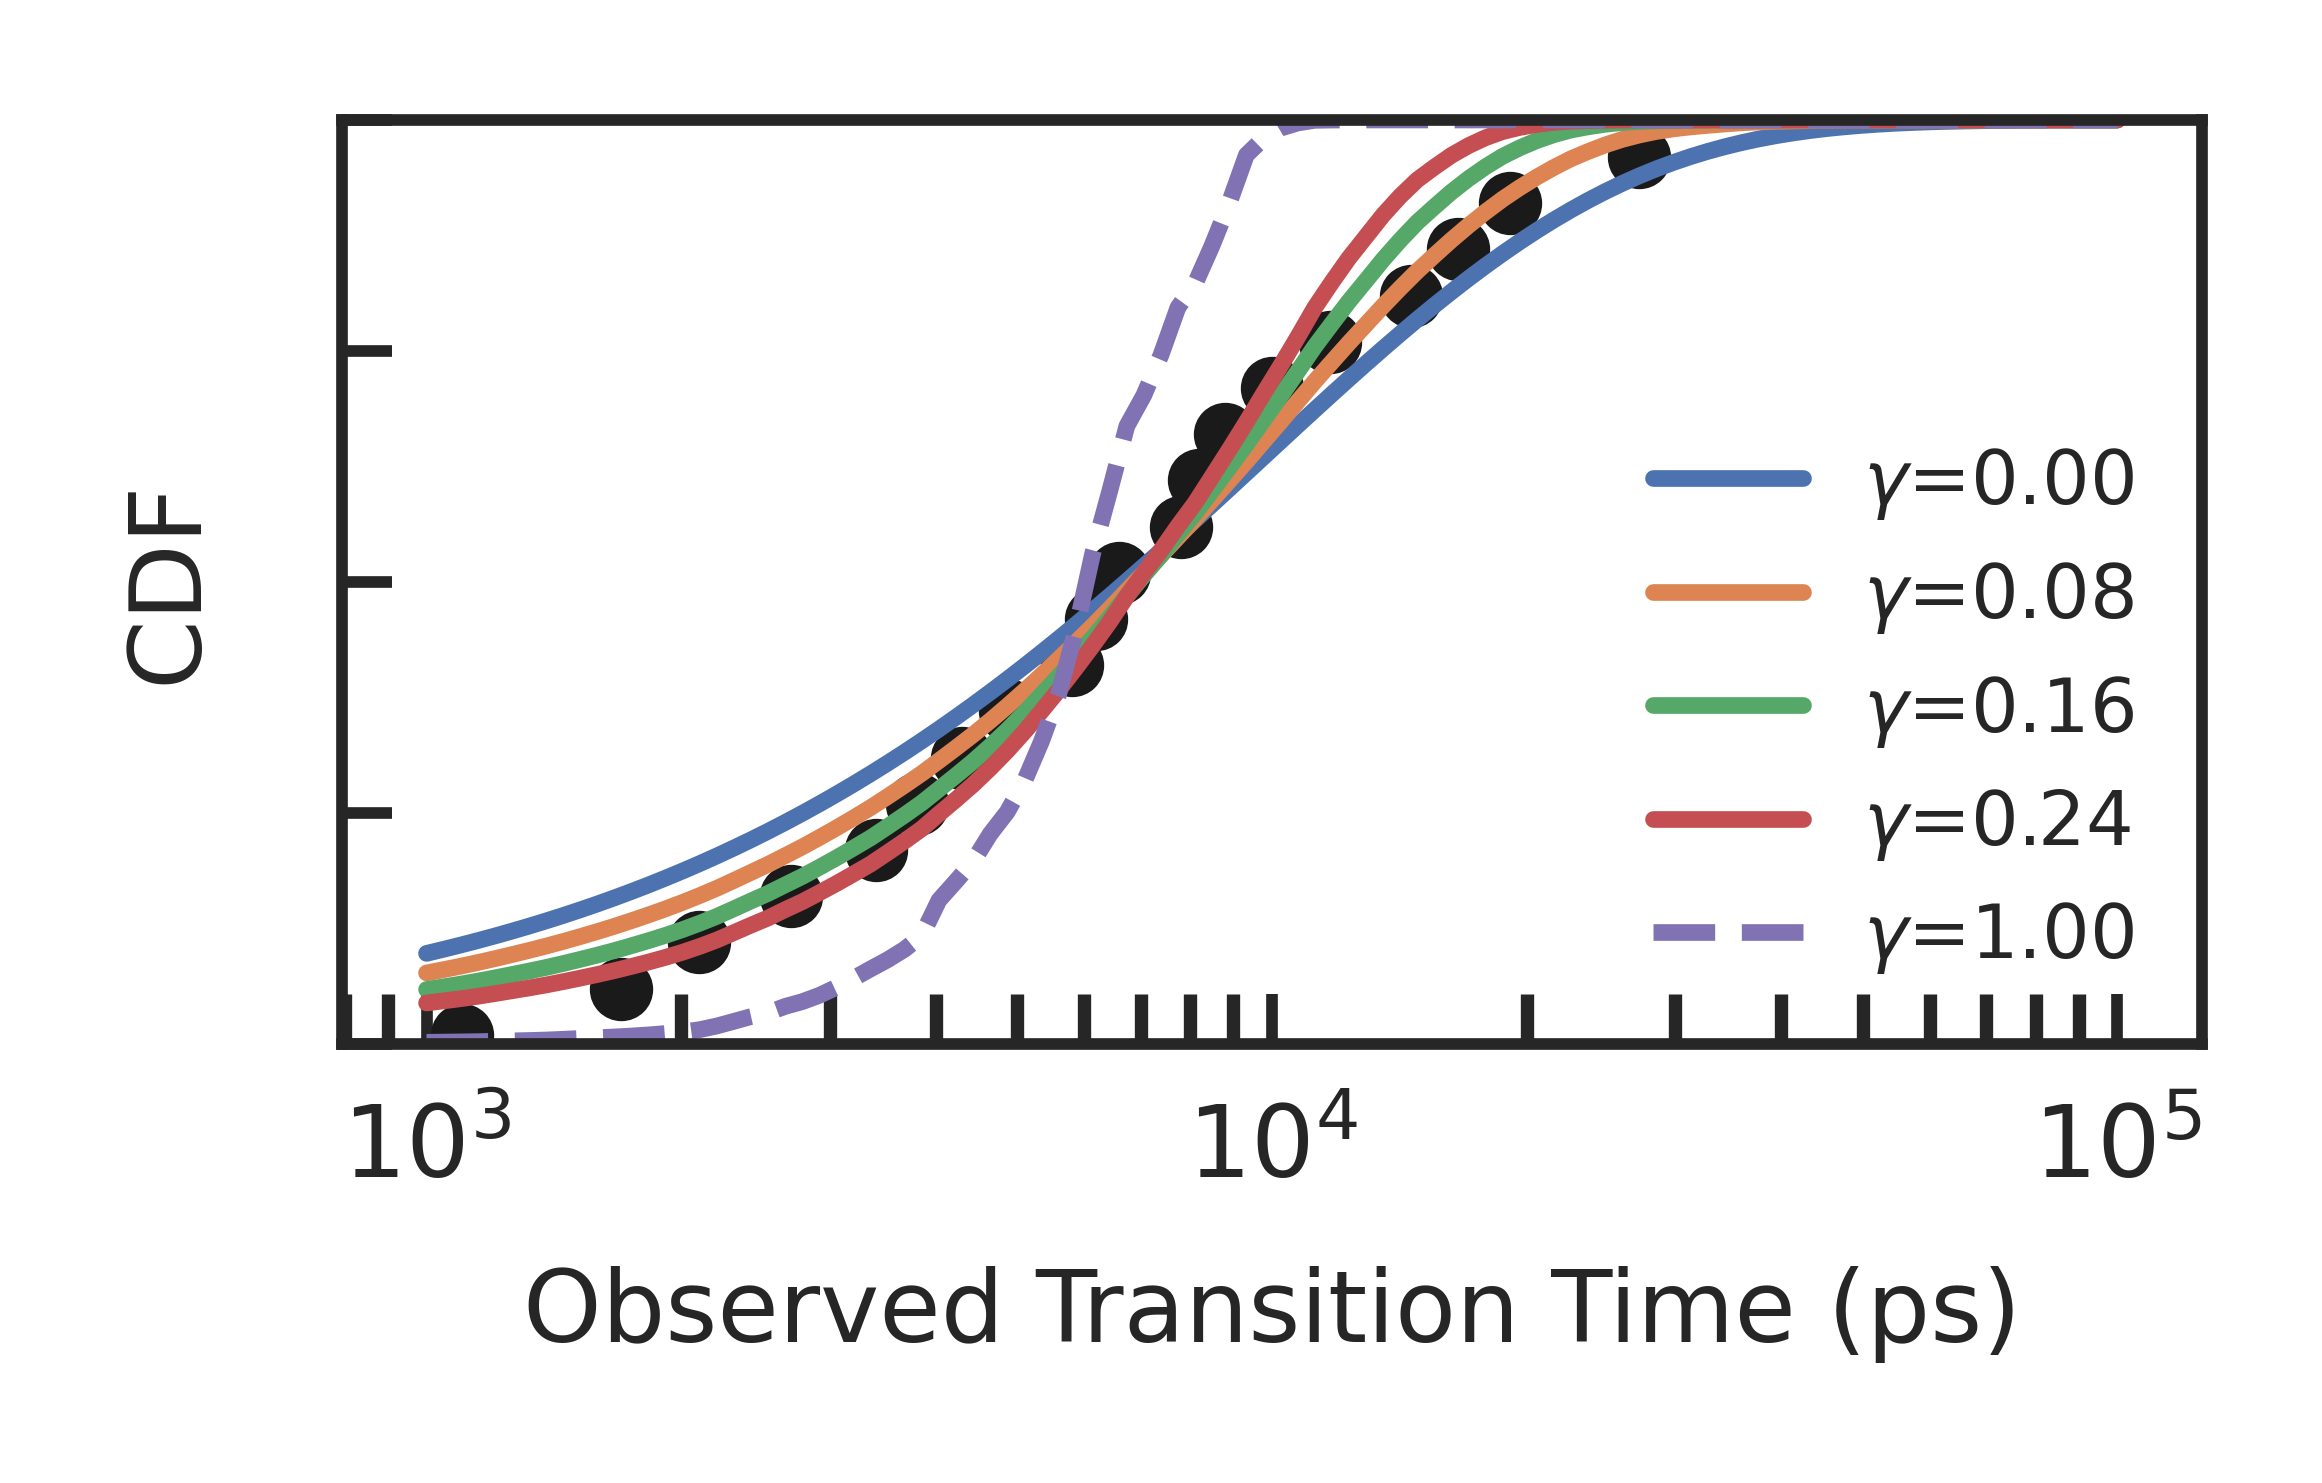

In [25]:
sns.set_theme()
sns.set_context('paper', rc={'axes.labelsize': 6, 'axes.linewidth': 0.7, 'lines.linewidth': 1.0, 'axes.titlesize': 8,
                             'xtick.labelsize': 6, 'ytick.labelsize': 6, 'xtick.major.width': 0.7, 'ytick.major.width': 0.7,
                             'legend.fontsize': 4.5, 'legend.framealpha': 0, 'lines.markersize': 3})
sns.set_style('ticks')

fig = plt.figure(figsize=(2,1),dpi=1200)
ax = fig.add_subplot()

ax.set_xscale("log")
ax.set_xlabel("Observed Transition Time (ps)")
ax.set_ylabel("CDF")
ax.set_yticks([0.0,0.25,0.5,0.75,1.0],labels=["","","","",""])
ax.set_ylim((0,1))
ax.plot(ts,tcdf_ys[0],label='$\\gamma$=0.00')
ax.plot(ts,tcdf_ys[1],label='$\\gamma$=0.08')
ax.plot(ts,tcdf_ys[2],label='$\\gamma$=0.16')
ax.plot(ts,tcdf_ys[3],label='$\\gamma$=0.24')
ax.plot(ts,tcdf_ys[4],label='$\\gamma$=1.00',linestyle='--')
ax.scatter(ecdf_data[::5,0],ecdf_data[::5,1],color='k')
ax.legend(frameon=False)
ax.tick_params(axis='both', direction='in', which='both', length=3)

## Protein G RMSD $\gamma$ Ranges; $\Delta=10^5$

In [27]:
directory = "../Data/R_RMSD_wt/rruns_pace1e5"

gammas = [0.48,0.64,0.80,0.96,1.00]
print(gammas)

ecdfx, M = just_times(directory, 'metad.colvar', 'p.log', 159)
ecdfy = np.arange(1, M + 1) / 100.
ecdf_data=np.column_stack((ecdfx, ecdfy))

ts = 10**np.linspace(4,5.5,100)

colvars = []
runs = [f"run_{i+1}" for i in range(100)]
for run in runs:
    colvars.append(f"{directory}/{run}/metad.colvar")
colvars_count = len(colvars)
colvars_maxrow_count = None
data = []
for colvar in colvars:
    data.append(np.loadtxt(colvar))
    colvars_maxrow_count = data[-1].shape[0] if colvars_maxrow_count is None or colvars_maxrow_count < data[-1].shape[0] else colvars_maxrow_count

v_data, ix_col = RM.inst_bias(data, colvars_count, colvars_maxrow_count, 0.3855097673, 2)

[0.48, 0.64, 0.8, 0.96, 1.0]


In [28]:
tcdf_ys = []

def tcdf(t, k0, gamma):
    spline = RM.EATR_calculate_avg_acc(gamma, v_data, 0.3855097673, ix_col)
    return RM.EATR_CDF(t, k0, gamma, spline, 1)

for gamma in gammas:
    cdf_result = optimize.curve_fit(tcdf, ecdf_data[:,0], ecdf_data[:,1], p0=(1e-5,gamma), bounds=([1e-8,gamma-0.0000001],[1e-3,gamma]))
    cdf_result = cdf_result[0]
    tcdf_ys.append(tcdf(ts,cdf_result[0],cdf_result[1]))
    print(f"gamma: {cdf_result[1]}, k0: {cdf_result[0]}")

gamma: 0.47999999880558475, k0: 3.9148109555485735e-06
gamma: 0.6399999974958429, k0: 2.972882860679323e-06
gamma: 0.7999999980447805, k0: 2.2044952663498083e-06
gamma: 0.9599999975727896, k0: 1.5976640468395964e-06
gamma: 0.9999999999886359, k0: 1.4689907302486968e-06


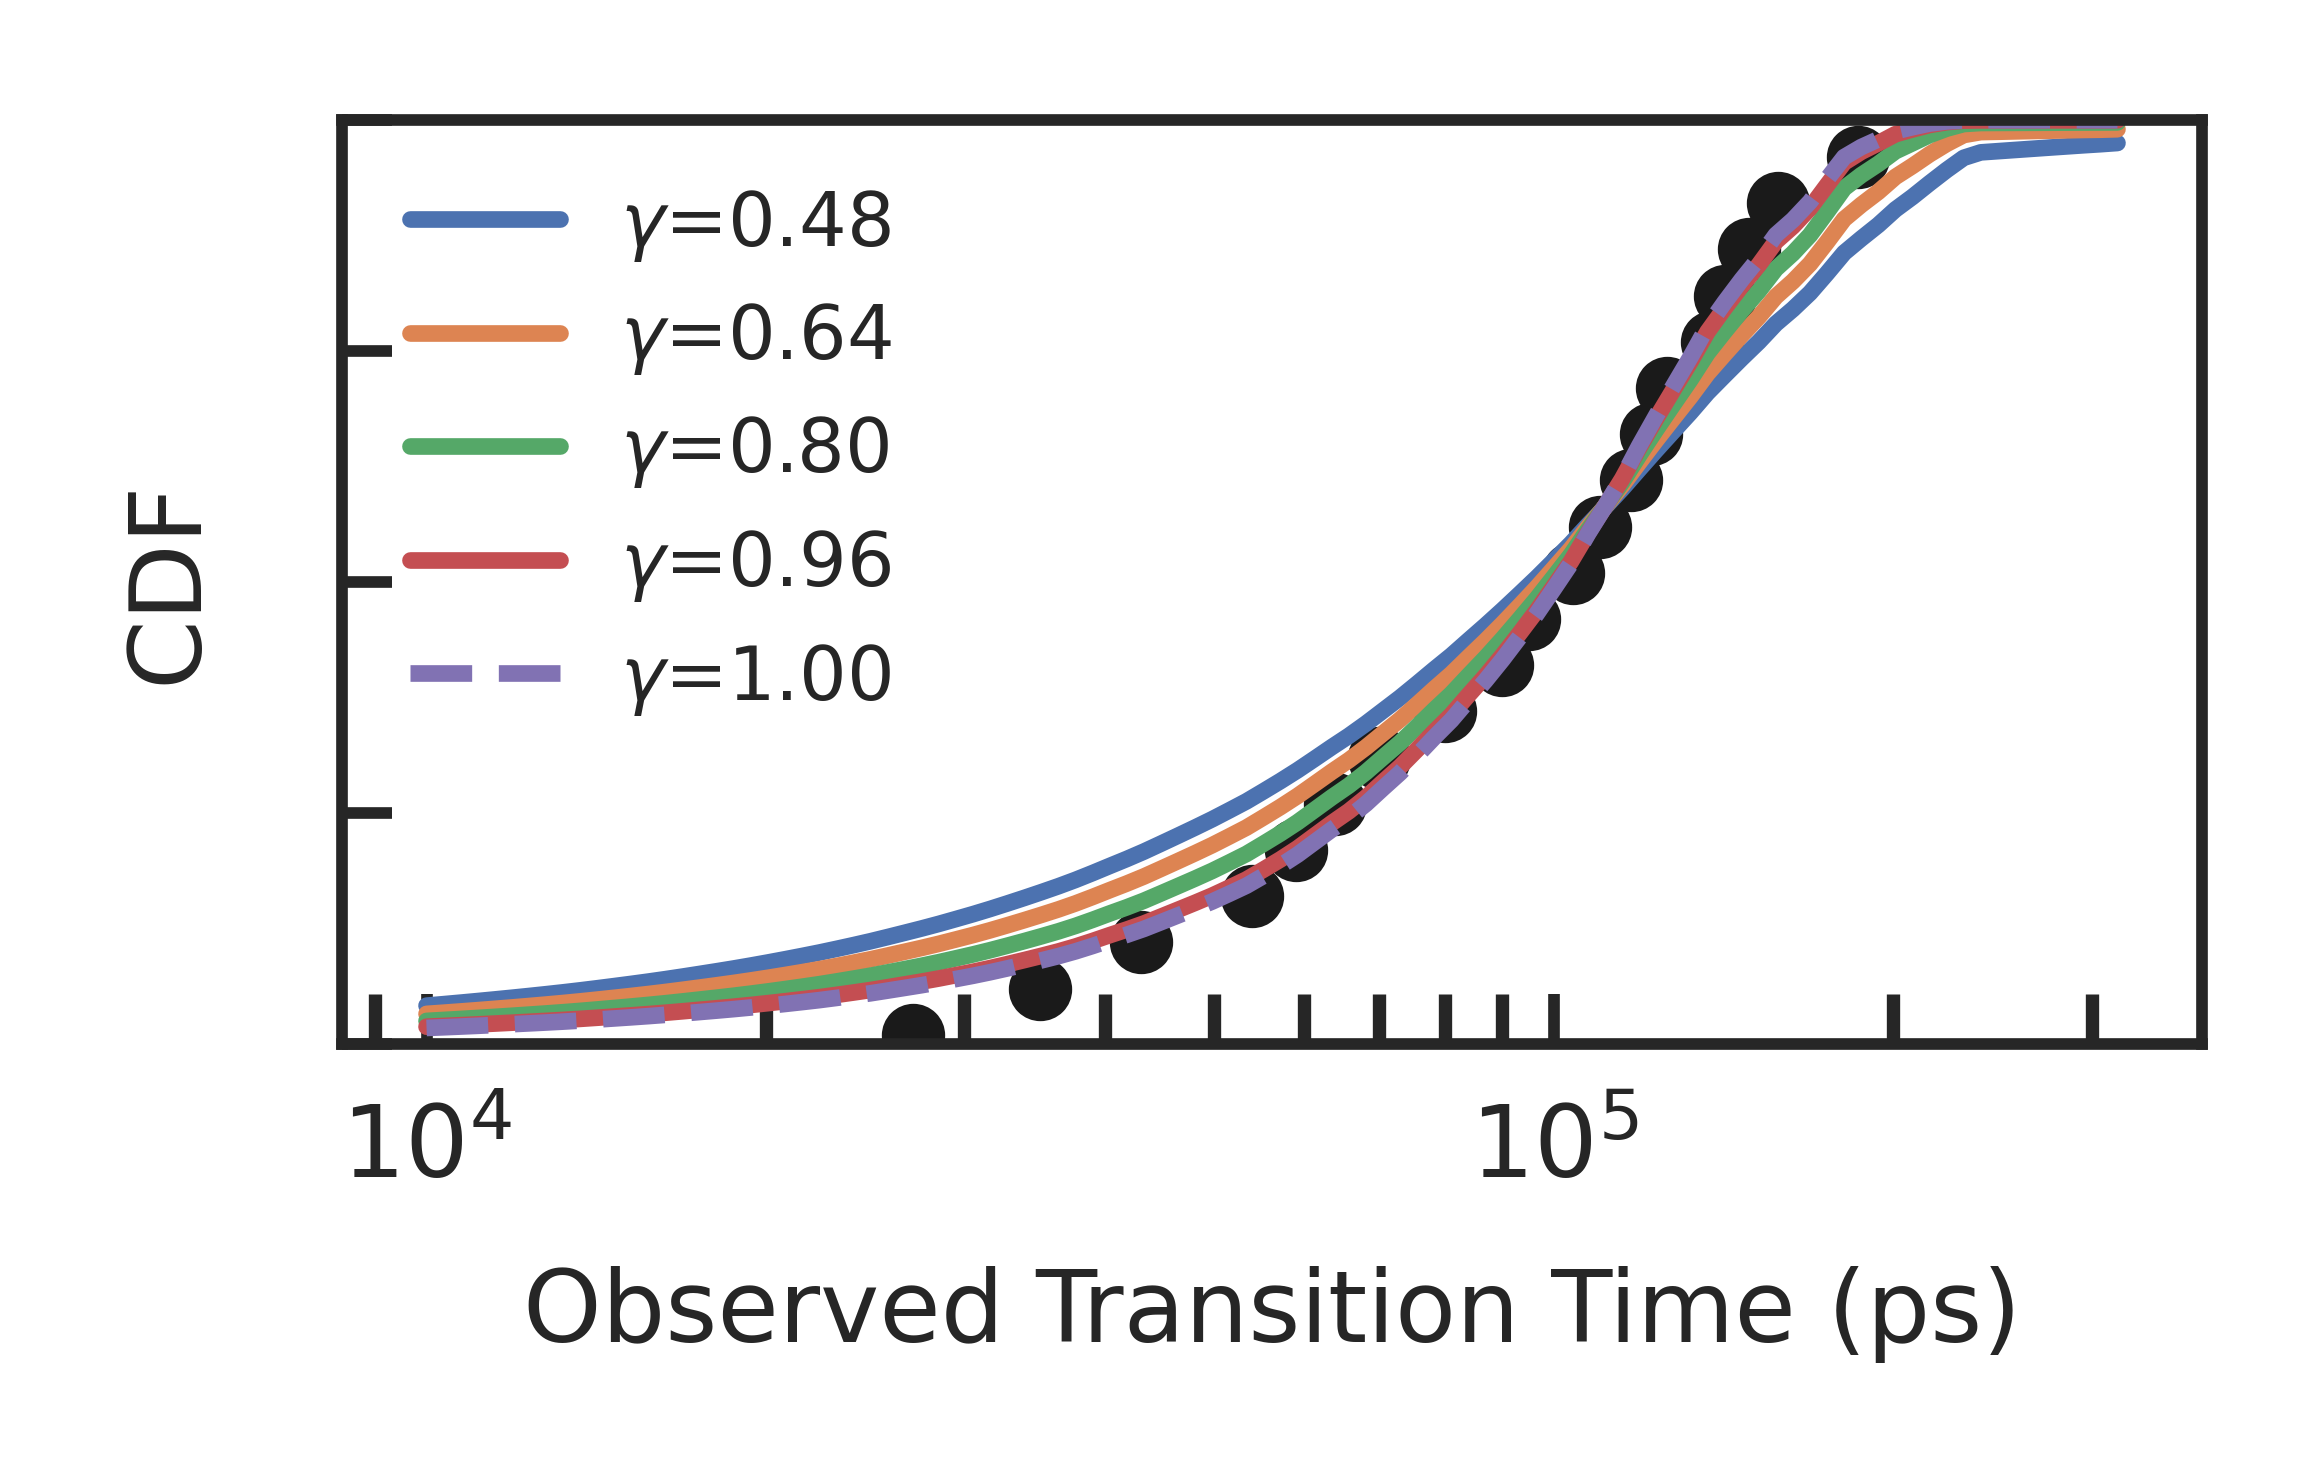

In [29]:
sns.set_theme()
sns.set_context('paper', rc={'axes.labelsize': 6, 'axes.linewidth': 0.7, 'lines.linewidth': 1.0, 'axes.titlesize': 8,
                             'xtick.labelsize': 6, 'ytick.labelsize': 6, 'xtick.major.width': 0.7, 'ytick.major.width': 0.7,
                             'legend.fontsize': 4.5, 'legend.framealpha': 0, 'lines.markersize': 3})
sns.set_style('ticks')

fig = plt.figure(figsize=(2,1),dpi=1200)
ax = fig.add_subplot()

ax.set_xscale("log")
ax.set_xlabel("Observed Transition Time (ps)")
ax.set_ylabel("CDF")
ax.set_yticks([0.0,0.25,0.5,0.75,1.0],labels=["","","","",""])
ax.set_ylim((0,1))
ax.plot(ts,tcdf_ys[0],label='$\\gamma$=0.48')
ax.plot(ts,tcdf_ys[1],label='$\\gamma$=0.64')
ax.plot(ts,tcdf_ys[2],label='$\\gamma$=0.80')
ax.plot(ts,tcdf_ys[3],label='$\\gamma$=0.96')
ax.plot(ts,tcdf_ys[4],label='$\\gamma$=1.00',linestyle='--')
ax.scatter(ecdf_data[::5,0],ecdf_data[::5,1],color='k')
ax.legend(frameon=False)
ax.tick_params(axis='both', direction='in', which='both', length=3)